In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import pvlib
from pvlib import pvsystem, modelchain
from pvlib.location import Location
from pvlib.iotools import read_epw, read_tmy3


import matplotlib.pyplot as plt

from src.surface import *
from src.view_profile import *
from src.building import Building
from src.site import *
from src.array import SurfaceArray

from src.torbreck.torbreck import load_torbreck

In [5]:
torbreck = load_torbreck()

/workspace/src/site.py:52: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  tmy.index = tmy.index + pd.DateOffset(year=2013)


In [6]:
captured = torbreck.captured_irradiance

In [ ]:
generated_power = df_long.groupby('Datetime')['Generation (kWh)'].sum()
generated_power.to_csv('data/torbreck/generated.csv')
df_long.to_csv('data/torbreck/generated_by_surface.csv')

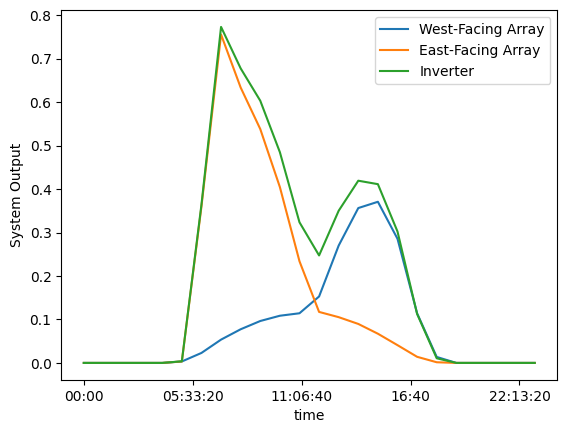

In [4]:
# Test of PV modules simulation
array_kwargs = dict(
    module_parameters=dict(pdc0=1, gamma_pdc=-0.004),
    temperature_model_parameters=dict(a=-3.56, b=-0.075, deltaT=3)
)

arrays = [
    SurfaceArray(pvsystem.FixedMount(90, 270),
                 name='West-Facing Array', Surface_profile=Surface_W.Surface_profile, **array_kwargs),
    SurfaceArray(pvsystem.FixedMount(90, 90),
                 name='East-Facing Array', Surface_profile=Surface_E.Surface_profile, **array_kwargs),
]


system = pvsystem.PVSystem(arrays=arrays, inverter_parameters=dict(pdc0=3))
mc = modelchain.ModelChain(system, site.location, aoi_model='physical',
                           spectral_model='no_loss')


mc.run_model(site.tmy)

fig, ax = plt.subplots()
for array, pdc in zip(system.arrays, mc.results.dc):
    pdc.groupby(
        pdc.index.time
    ).mean().plot(label=f'{array.name}')

inverter = mc.results.ac
inverter.groupby(inverter.index.time).mean().plot(label='Inverter')
plt.ylabel('System Output')
plt.legend()
plt.show()